<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_1701_imbalanced_data_resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem of Class Imbalance

**Class imbalance** occurs when one class in a dataset significantly outnumbers the other classes. This is common in many real-world scenarios, such as fraud detection, medical diagnoses, and loan defaults. In such cases, the majority class (the more frequent class) dominates the dataset, while the minority class (the less frequent class) is underrepresented.

### Impact on Model Performance

When training a machine learning model on imbalanced data, the model tends to become biased towards the majority class. This bias can lead to the following issues:

1. **High Accuracy but Poor Minority Class Performance**: The model may achieve high overall accuracy by simply predicting the majority class most of the time. However, it will likely perform poorly on the minority class, failing to identify critical instances.

2. **High Precision and Recall for the Majority Class**: Precision and recall scores for the majority class may be high because the model is good at predicting the majority class correctly. However, this often comes at the expense of poor performance for the minority class.

3. **Low Precision and Recall for the Minority Class**: Precision and recall scores for the minority class are typically low because the model struggles to correctly identify minority class instances. This is problematic in scenarios where identifying the minority class correctly is crucial (e.g., detecting fraudulent transactions or diagnosing diseases).

### Load & Preprocess Data

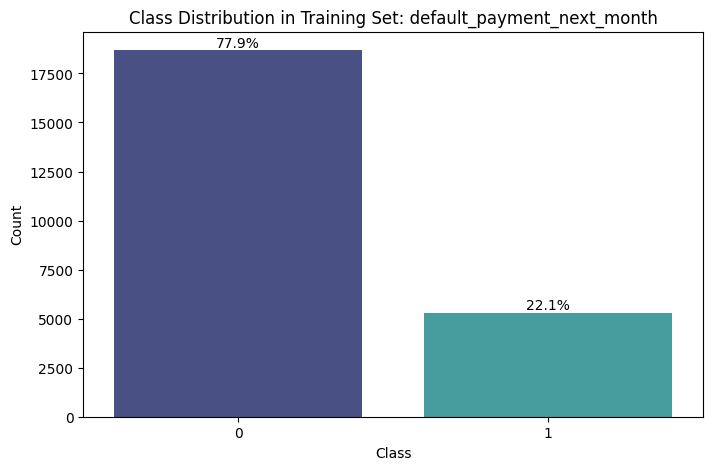

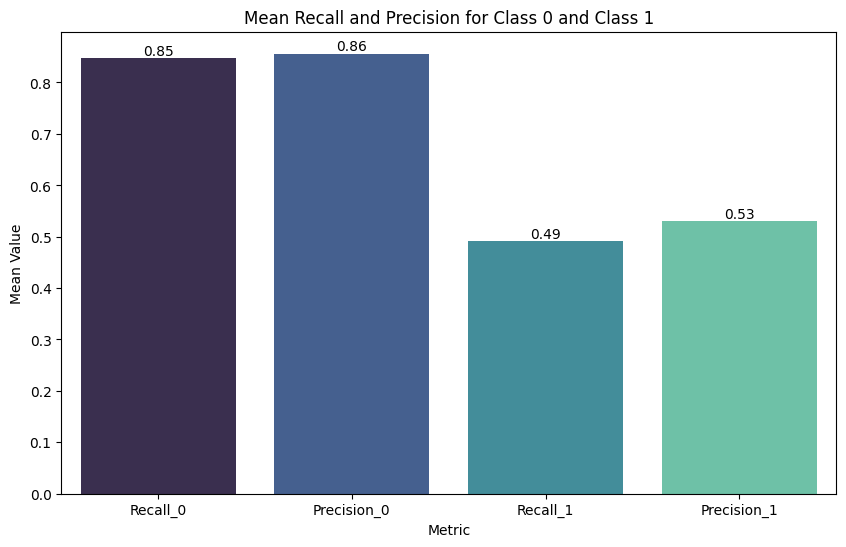

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import warnings
from loan_data_utils import load_and_preprocess_data, plot_class_distribution, plot_mean_class_metrics, get_top_performers, evaluate_model

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])


from loan_data_utils import plot_mean_class_metrics
# Load the CSV file into a DataFrame
file_path = '/content/combined_model_metrics_with_resampling.csv'
metrics_df = pd.read_csv(file_path)

# plot metrics
plot_class_distribution(y_train, target)
plot_mean_class_metrics(metrics_df)

## Resample Methods - Under & Over Sample

When using both SMOTE and undersampling, the order in which they are applied can be crucial to achieving a balanced dataset effectively.

Here is an explanation and code snippet to ensure clarity on how both resampling techniques are used together:

### Combining SMOTE and Undersampling

1. **SMOTE (Synthetic Minority Over-sampling Technique):**
   - SMOTE generates synthetic samples for the minority class (class 1) to oversample it.

2. **Random UnderSampling:**
   - After applying SMOTE, RandomUnderSampler is used to undersample the majority class (class 0).

### Resampling Script

In [5]:
script_content = '''
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

def plot_class_distribution(y_train, target_name, method_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution for {target_name} with {method_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

def adjust_threshold(model_pipeline, X_test, y_test, threshold):
    y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    return classification_report(y_test, y_pred, output_dict=True)


'''

# Write the script to a file
with open("resampling_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to resampling_utils.py")
# Reload script to make functions available for use
import importlib
import resampling_utils
importlib.reload(resampling_utils)

from resampling_utils import *

Script successfully written to resampling_utils.py


### Resample Pipeline

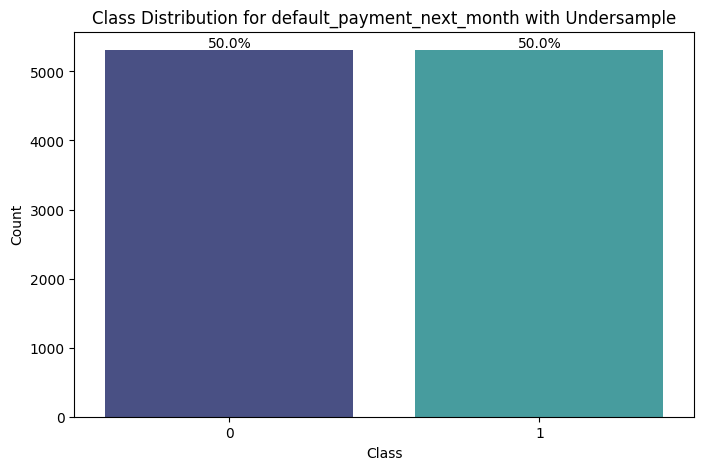

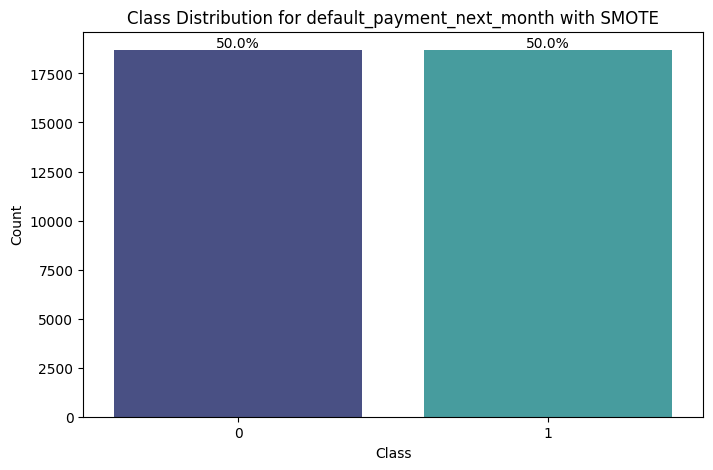

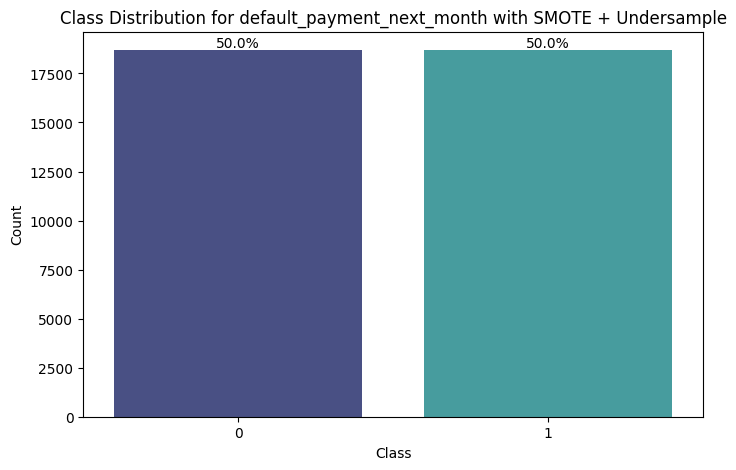

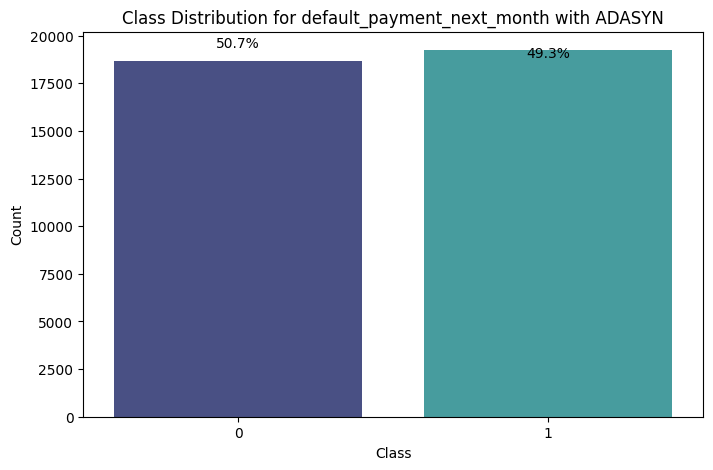

Classification reports saved to 'resampling_comparison_results.json'


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
import warnings
import json
from loan_data_utils import load_and_preprocess_data
from resampling_utils import plot_class_distribution, adjust_threshold

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define resampling methods
resampling_methods = {
    'Undersample': RandomUnderSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'SMOTE + Undersample': ImbPipeline(steps=[('smote', SMOTE(random_state=42)), ('under', RandomUnderSampler(random_state=42))]),
    'ADASYN': ADASYN(random_state=42)
}

# Define the logistic regression model
log_reg = LogisticRegression(class_weight='balanced', max_iter=3000, random_state=42)

# Loop through resampling methods, train model, adjust thresholds, and save classification reports
results = {}
thresholds = [0.2, 0.25, 0.3, 0.35, 0.4]

for method_name, resampler in resampling_methods.items():
    # Apply resampling
    X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

    # Plot class distribution after resampling
    plot_class_distribution(y_resampled, target, method_name)

    # Create a pipeline with preprocessing and logistic regression
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', log_reg)
    ])

    # Train the model on the resampled data
    model_pipeline.fit(X_resampled, y_resampled)

    # Generate and save classification reports for each threshold
    method_results = {}
    for threshold in thresholds:
        method_results[f'Threshold {threshold}'] = adjust_threshold(model_pipeline, X_test, y_test, threshold)

    results[method_name] = method_results

# Save results to a JSON file
with open('resampling_comparison_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("Classification reports saved to 'resampling_comparison_results.json'")


### Model Performance Comparison

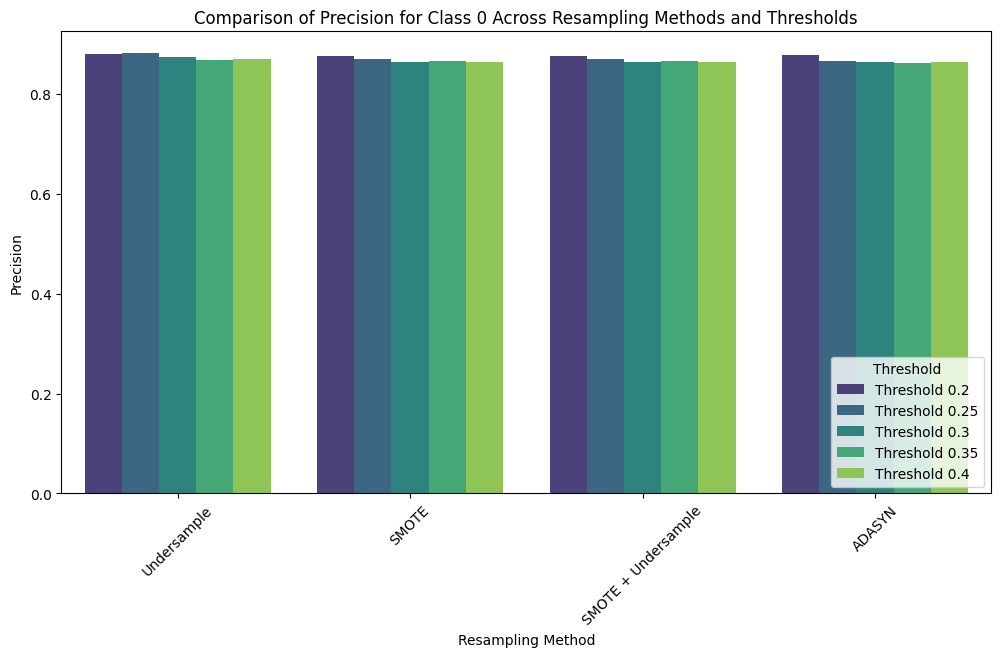

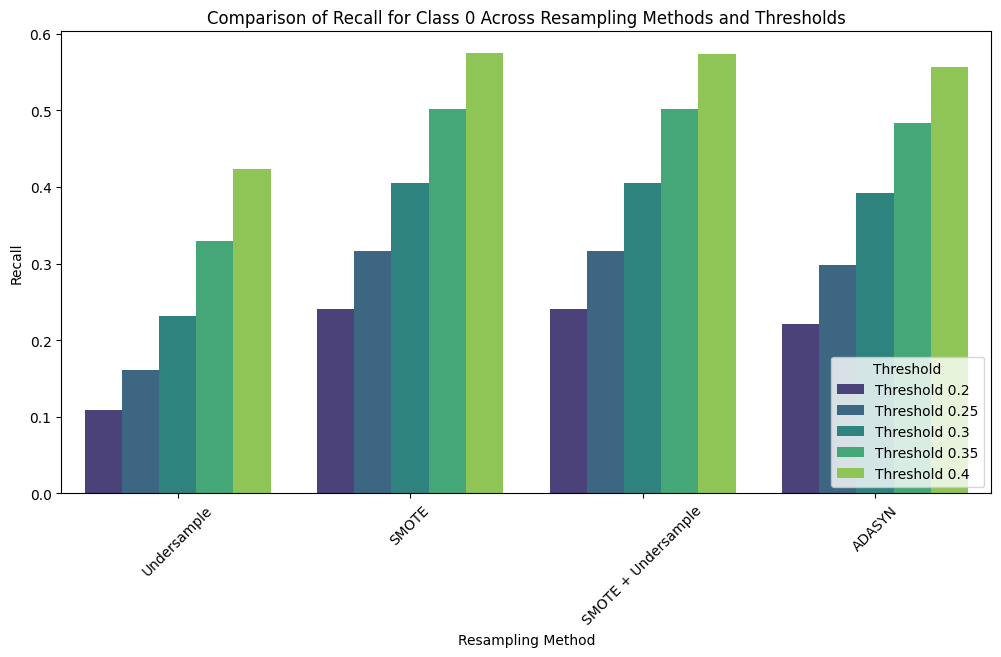

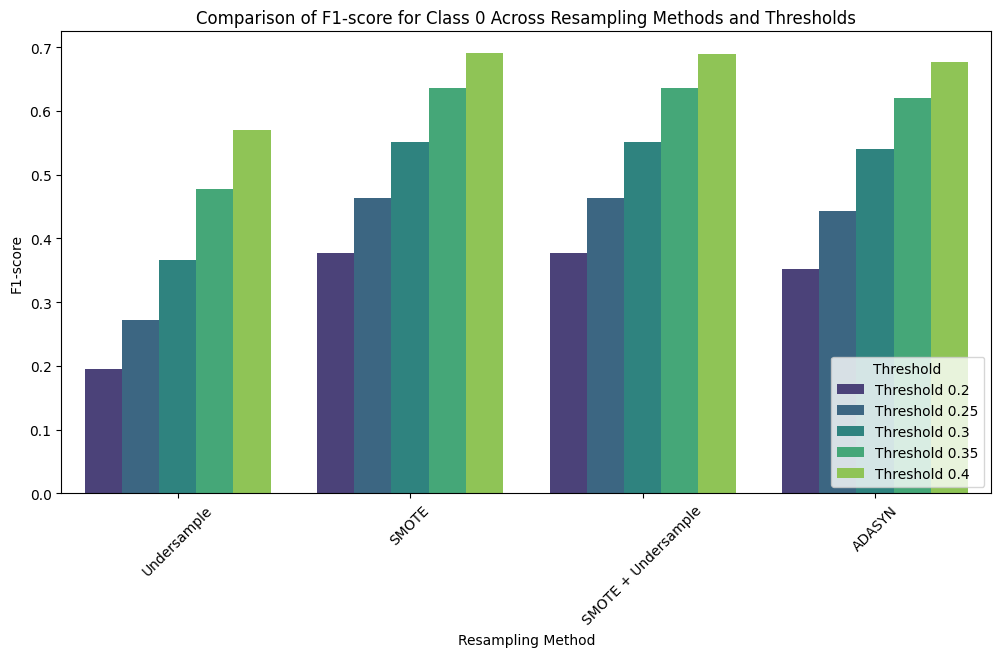

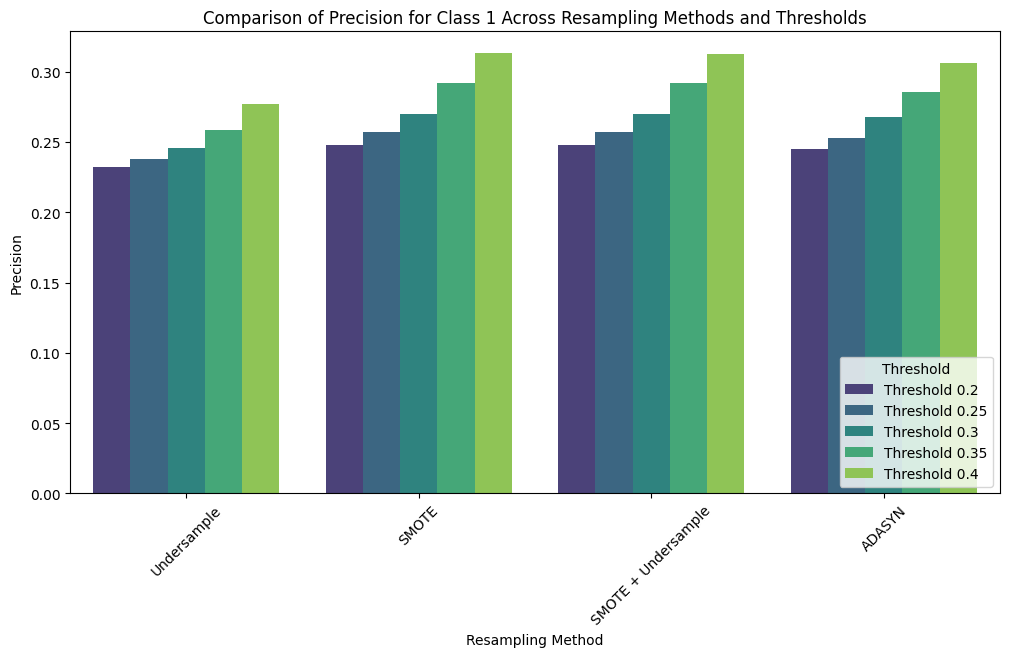

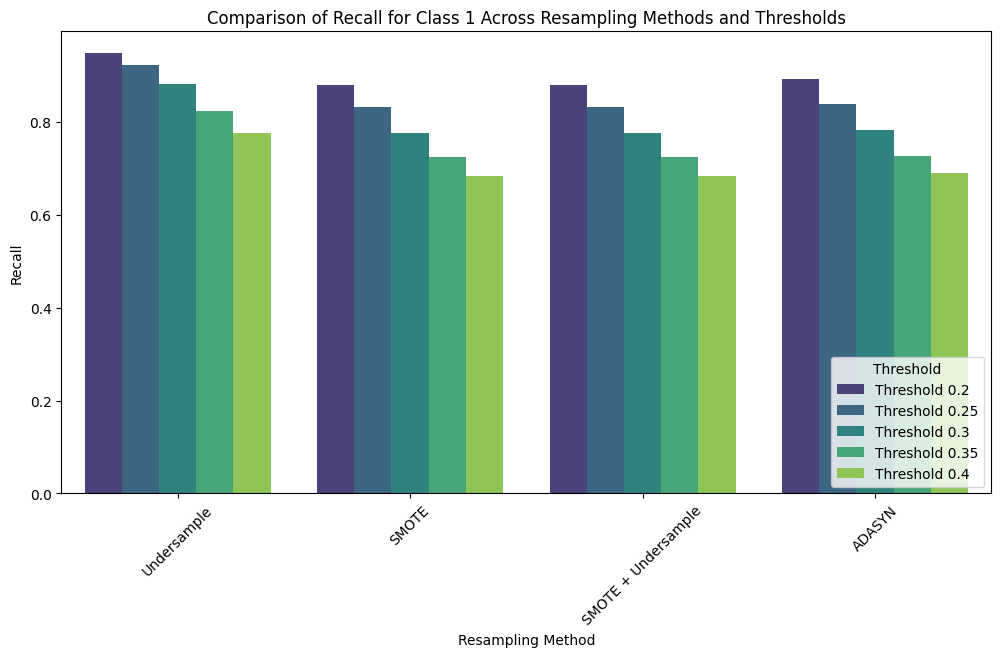

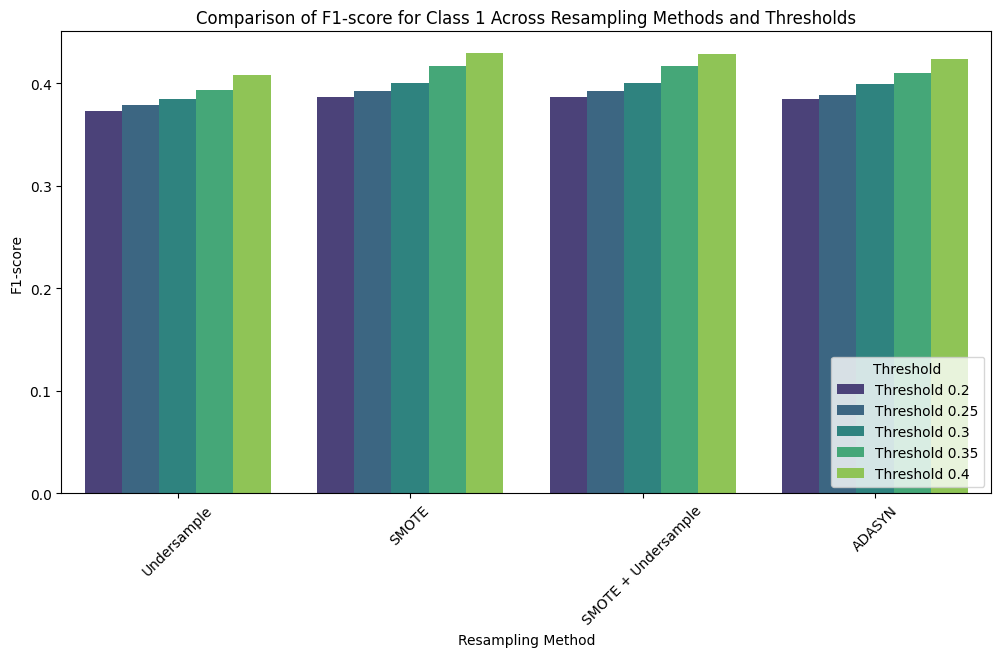

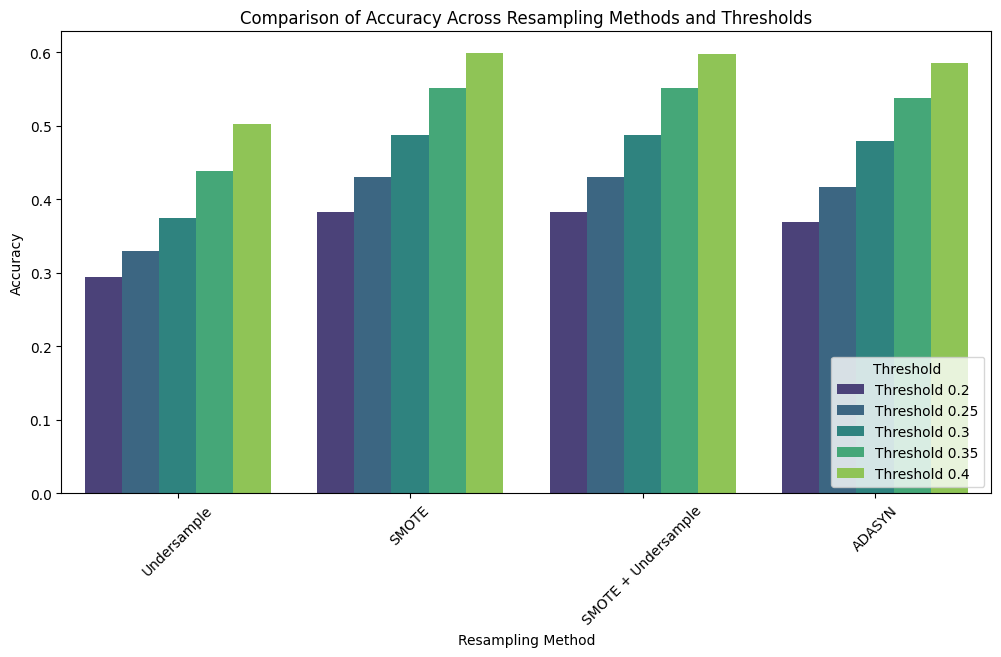

In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the classification reports from the JSON file
with open('resampling_comparison_results.json', 'r') as f:
    results = json.load(f)

# Extract and process the metrics
def extract_metrics(results):
    data = []
    for method, thresholds in results.items():
        for threshold, report in thresholds.items():
            row = {
                'Method': method,
                'Threshold': threshold,
                'Precision Class 0': report['0']['precision'],
                'Recall Class 0': report['0']['recall'],
                'F1-score Class 0': report['0']['f1-score'],
                'Precision Class 1': report['1']['precision'],
                'Recall Class 1': report['1']['recall'],
                'F1-score Class 1': report['1']['f1-score'],
                'Accuracy': report['accuracy']
            }
            data.append(row)
    return pd.DataFrame(data)

# Extract metrics for both classes
metrics_df = extract_metrics(results)

# Plot the performance metrics
def plot_metrics(metrics_df, metric, class_label):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Method', y=f'{metric} Class {class_label}', hue='Threshold', palette='viridis', data=metrics_df)
    plt.title(f'Comparison of {metric} for Class {class_label} Across Resampling Methods and Thresholds')
    plt.ylabel(metric)
    plt.xlabel('Resampling Method')
    plt.legend(title='Threshold', loc='lower right')
    plt.xticks(rotation=45)
    plt.show()

# Plot precision, recall, F1-score for Class 0 and Class 1
plot_metrics(metrics_df, 'Precision', 0)
plot_metrics(metrics_df, 'Recall', 0)
plot_metrics(metrics_df, 'F1-score', 0)
plot_metrics(metrics_df, 'Precision', 1)
plot_metrics(metrics_df, 'Recall', 1)
plot_metrics(metrics_df, 'F1-score', 1)

# Plot accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x='Method', y='Accuracy', hue='Threshold', palette='viridis', data=metrics_df)
plt.title('Comparison of Accuracy Across Resampling Methods and Thresholds')
plt.ylabel('Accuracy')
plt.xlabel('Resampling Method')
plt.legend(title='Threshold', loc='lower right')
plt.xticks(rotation=45)
plt.show()


The trade-off between precision and recall is a common challenge in classification tasks, especially with imbalanced datasets. Understanding this trade-off and how to manage it is crucial for building effective models.

### Precision and Recall Trade-off

- **Precision:** Measures the proportion of true positive predictions among all positive predictions. High precision means that when the model predicts a positive class, it is usually correct.

- **Recall (Sensitivity):** Measures the proportion of true positive predictions among all actual positive cases. High recall means that the model captures most of the positive cases.

- **Trade-off:** When you increase recall by lowering the threshold for classifying positives, you may also increase the number of false positives, thus reducing precision. Conversely, increasing precision by raising the threshold usually decreases recall because you miss more actual positives.


### Strategies to Handle the Trade-off

1. **Adjusting the Decision Threshold:** You can find an optimal threshold that balances precision and recall according to your specific needs. This is what we have been doing with the threshold adjustments.

2. **Cost-sensitive Learning:** Assign different costs to false positives and false negatives. For instance, false negatives (missing a loan default) may be more costly than false positives (predicting default when there isn't one).

3. **Resampling Techniques:** Using methods like SMOTE, undersampling, and oversampling to balance the classes can help improve the model's ability to detect minority class samples without heavily compromising on precision.

4. **Ensemble Methods:** Combine multiple models to improve performance. For example, using a VotingClassifier with different models can sometimes balance precision and recall better than a single model.

5. **Custom Evaluation Metric:** Define a custom metric that combines precision and recall in a way that aligns with business needs, such as a weighted F1 score.

6. **Post-processing:** Apply rules or secondary models to adjust predictions based on additional criteria or business logic.



### Summary

1. **Understanding Trade-offs:** High precision may come at the cost of low recall and vice versa.
2. **Choosing the Right Metric:** Use the F1 score, precision-recall curve, and other metrics to find the right balance.
3. **Optimizing the Model:** Adjust thresholds, use resampling techniques, and consider cost-sensitive learning to improve performance.

Data scientists often iterate through these strategies, constantly balancing and tuning to achieve the best possible performance for the given problem.

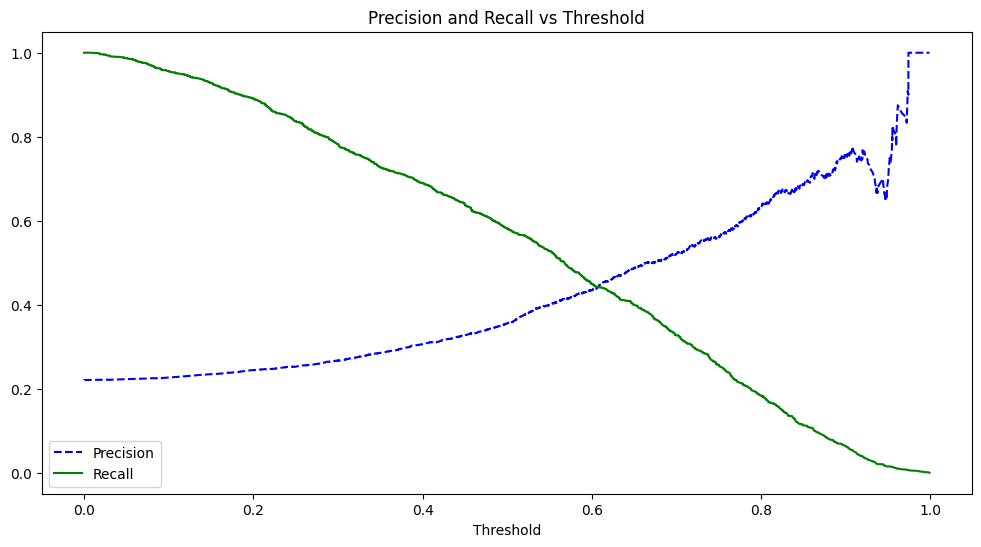

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.title("Precision and Recall vs Threshold")
    plt.show()

def plot_precision_recall_curve(y_test, y_pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# Example usage with a model pipeline and test data
model_pipeline.fit(X_resampled, y_resampled)  # Make sure your model is trained on resampled data
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
plot_precision_recall_curve(y_test, y_pred_proba)

#### Data Utils Script

In [2]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

#--------   Plot Class Distribution   --------#


def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

def plot_mean_class_metrics(df):
    """
    Function to calculate and plot the mean recall and precision metrics for class 0 and class 1.
    """
    # Calculate the mean of recall and precision for both classes
    metrics_df = pd.DataFrame({
        'Metric': ['Recall_0', 'Precision_0', 'Recall_1', 'Precision_1'],
        'Mean Value': [
            df['Recall_0'].mean(),
            df['Precision_0'].mean(),
            df['Recall_1'].mean(),
            df['Precision_1'].mean()
        ]
    })

    # Plot the mean of recall and precision for each class
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Metric', y='Mean Value', data=metrics_df, palette='mako')
    plt.title('Mean Recall and Precision for Class 0 and Class 1')
    plt.xlabel('Metric')
    plt.ylabel('Mean Value')
    for index, row in metrics_df.iterrows():
        plt.text(index, row['Mean Value'], f'{row["Mean Value"]:.2f}', ha='center', va='bottom')
    plt.show()

#--------   Evaluate and Capture Metrics   --------#

# Function to evaluate model
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name):
    logger.info(f"Training and evaluating model: {model_name} ({experiment_name})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Experiment': experiment_name,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }
    return metrics

def compile_metrics(metrics_list, experiment_name='experiment_name'):
    metrics_df = pd.DataFrame(metrics_list)
    csv_filename = f'{experiment_name}_metrics.csv'
    metrics_df.to_csv(csv_filename, index=False)
    logger.info(f"Metrics saved to {csv_filename}")
    return metrics_df


def clean_params(params):
    """
    Clean the model parameters by removing the 'classifier__' prefix.
    """
    return {key.replace('classifier__', ''): value for key, value in params.items()}

# --------   Get Top Performers   --------#

import pandas as pd
def get_top_performers(metrics_df, top_n=3):
    metrics = ['Recall_0', 'Precision_0', 'Recall_1', 'Precision_1']
    top_performers = []

    for metric in metrics:
        sorted_df = metrics_df[['Experiment', 'Model', metric]].sort_values(by=metric, ascending=False).head(top_n)
        sorted_df['Metric'] = metric
        sorted_df = sorted_df.rename(columns={metric: 'Value'})
        top_performers.append(sorted_df)

    # Concatenate all top performers into a single DataFrame
    top_performers_df = pd.concat(top_performers, ignore_index=True)

    # Save the results to a CSV file
    top_performers_df.to_csv('top_performing_models.csv', index=False)
    return top_performers_df

def select_and_sort_top_n(df, columns, n=3):
    """
    Selects the top n rows based on each specified column and returns a DataFrame with all columns.

    Args:
    df (pd.DataFrame): The input DataFrame.
    columns (list of str): The columns to sort by.
    n (int): The number of top rows to select for each column.

    Returns:
    pd.DataFrame: A DataFrame containing the top n rows for each specified column, without duplicates.
    """
    top_n_combined_df = pd.DataFrame()

    for column in columns:
        top_n = df.nlargest(n, column)
        top_n_combined_df = pd.concat([top_n_combined_df, top_n])

    # Drop duplicates and reset index
    top_n_combined_df = top_n_combined_df.drop_duplicates().reset_index(drop=True)

    return top_n_combined_df

'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py
